# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [3]:
pth1 = 'autos.csv'
pth2 = '/datasets/autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, parse_dates = ['DateCrawled', 'DateCreated', 'LastSeen'])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, parse_dates = ['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    print('Something is wrong')

In [4]:
shape = df.shape
print('Размер таблицы:', df.shape)

Размер таблицы: (354369, 16)


In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Удалим неинформативные признаки.

In [6]:
df = df.drop(['RegistrationMonth', 'DateCreated','LastSeen', 'PostalCode'], axis=1)

Признак 'DateCrawled' пока удалять не будем для того, чтобы отследить уникальность анкеты.

Переименуем названия признаков.

In [7]:
df = df.rename(columns = {'DateCrawled': 'Date_Crawled', 'VehicleType': 'Vehicle_Type', 'RegistrationYear': 'Registration_Year', 'FuelType': 'Fuel_Type',  'NumberOfPictures': 'Number_Of_Pictures'})

Приведем названия признаков к нижнему регистру.

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   fuel_type           321474 non-null  object        
 9   brand               354369 non-null  object        
 10  repaired            283215 non-null  object        
 11  number_of_pictures  354369 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 32.4+ MB


Проверим количество пропусков в %.

In [10]:
pd.DataFrame(round(df.isna().mean()*100,3)).style.background_gradient('coolwarm')

,0
date_crawled,0.000000
price,0.000000
vehicle_type,10.579000
registration_year,0.000000
gearbox,5.597000
power,0.000000
model,5.561000
kilometer,0.000000
fuel_type,9.283000
brand,0.000000


In [11]:
list = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired'] #список признаков с пропусками
for i in list:
    display(df[i].value_counts(dropna=False))

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

manual    268251
auto       66285
NaN        19833
Name: gearbox, dtype: int64

golf                  29232
other                 24421
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 251, dtype: int64

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

no     247161
NaN     71154
yes     36054
Name: repaired, dtype: int64

Заполнимм пропуски в столбце vehicle_type самым популярным значением.

In [12]:
df['vehicle_type'] = df['vehicle_type'].fillna(df['vehicle_type'].mode()[0])

Заполнимм пропуски в столбце gearbox самым популярным значением.

In [13]:
df['gearbox'] = df['gearbox'].fillna(df['gearbox'].mode()[0])

Заменим пропуски в признаке model на категорию other.

In [14]:
df['model'] = df['model'].fillna('other')

Заполним пропуски в столбце fuel_type самым популярным значением и приведем названия бензина petrol и gasoline к единому значению petrol.

In [15]:
df['fuel_type'] = df['fuel_type'].fillna(df['fuel_type'].mode()[0])
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')

Если есть пропуск в repaired, будем с читать, что машина, как большинство, уже была в ремонте,поэтому заполним пропуски в признаке repaired на "yes".

In [16]:
df['repaired'] = df['repaired'].fillna('yes')

Проверим, устранены ли пропуски.

In [1]:
d.DataFrame(round(df.isna().mean()*100,3)).style.background_gradient('coolwarm')

NameError: name 'd' is not defined

In [18]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 26


Т.к в датасете присутствуют дата и время выгрузки анкеты, которые могут служить критерием уникальности строки, удалим найденные дубликаты.

Удалим дубликаты.

In [19]:
df = df.drop_duplicates().reset_index(drop=True)

Изучим характеристики признаков.

In [20]:
df.describe()

,price,registration_year,power,kilometer,number_of_pictures
count,354343.000000,354343.000000,354343.000000,354343.000000,354343.0
mean,4416.573941,2004.234575,110.091663,128212.268903,0.0
std,4514.167600,90.231244,189.856174,37904.444552,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,0.0


Заменим аномальные значения power на медиану.

In [21]:
median_power = df['power'].median()
df.loc[(df['power']<50)|(df['power']>4000), 'power'] = median_power

Изучим распределение price.

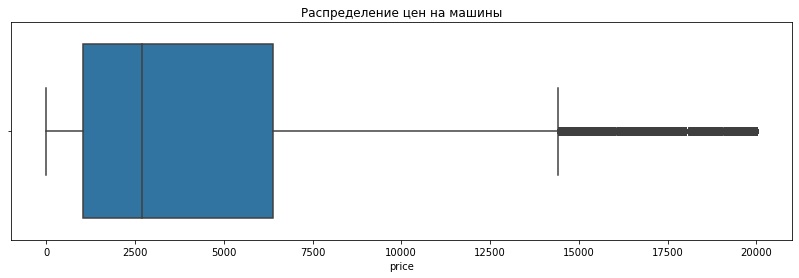

In [23]:
plt.rcParams['figure.figsize']=(14,4)
a = sns.boxplot(x=df['price'])
a.set_title('Распределение цен на машины');

In [24]:
df['price'].quantile([0.05, 0.95])

0.05      200.0
0.95    14600.0
Name: price, dtype: float64

Удалим выбросы признака price,ориентируясь на 0.05 и 0.95 квантили.

In [25]:
df = df.query('200<price<14600')

Признак number_of_pictures содержит только значения 0, удалим его из-за неинформативности.

In [ ]:
df = df.drop(['number_of_pictures'], axis=1)

Удалим стороки с аномальными значениями registration_year, где год регистрации больше года выгрузки данных.

In [27]:
df['date_crawled'] = pd.DatetimeIndex(df['date_crawled']).year
df = df.loc[df['date_crawled']>df['registration_year']]

Удалим стороки с аномальными значениями registration_year, меньшими даты изобретения автомобиля.

In [28]:
df = df.loc[df['registration_year']>1886]

Проверим,что нет машин с более поздним годом регистрации, чем текущий (т.к.нет данных о годе проведения исследования).

In [29]:
len(df.loc[(df['registration_year']>2023)])

0

Теперь можно удалить столбец date_crawled.

In [30]:
df = df.drop(['date_crawled'], axis=1)

Проверим характеристики признаков.

In [31]:
df.describe()

,price,registration_year,power,kilometer
count,295623.000000,295623.000000,295623.00000,295623.000000
mean,4067.339118,2001.998501,118.66437,130180.601645
std,3541.215808,6.277228,61.28242,35539.526129
min,202.000000,1910.000000,50.00000,5000.000000
25%,1250.000000,1999.000000,86.00000,125000.000000
50%,2850.000000,2002.000000,105.00000,150000.000000
75%,5999.000000,2006.000000,140.00000,150000.000000
max,14599.000000,2015.000000,3500.00000,150000.000000


In [32]:
print('Размер преобразованной таблицы:', df.shape)

Размер преобразованной таблицы: (295623, 10)


In [33]:
print('Удалено:', round((df.shape[0]/shape[0]-1)*(-100), 2), '% строк')

Удалено: 16.58 % строк


Построим тепловую карту корреляции.

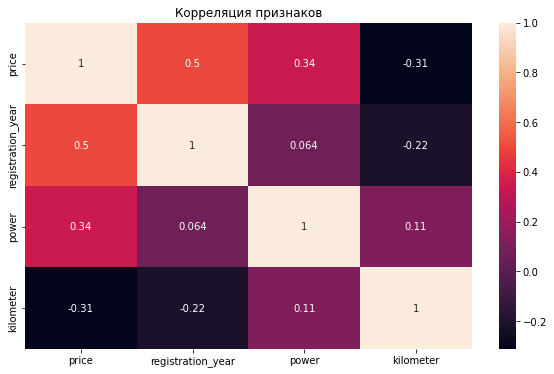

In [34]:
plt.rcParams['figure.figsize']=(10,6)
b = sns.heatmap(df.corr(), annot = True);
b.set_title('Корреляция признаков');

В датасетах не наблюдается мультиколлениарности признаков.

Изучим распределение целевого признака в датасете.

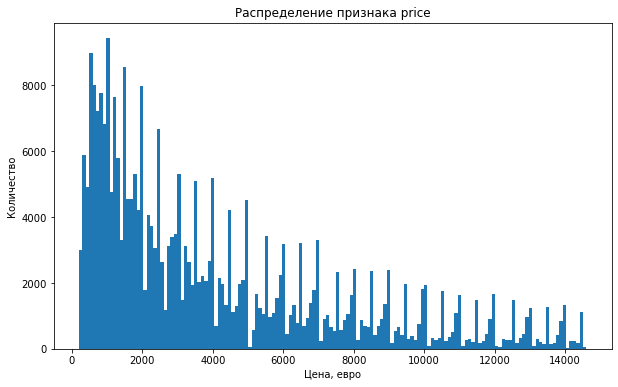

In [35]:
df['price'].plot(kind='hist', bins = 150, figsize=(10, 6), title='Распределение признака price')
plt.xlabel('Цена, евро')
plt.ylabel('Количество');

#### Подготовка выборок для обучения моделей

In [36]:
target = df['price'] #извлечем целевой признак
features = df.drop(['price'], axis=1) #извлечем признаки

Разделим данные на обучающую и тестовую выборки в соотношении 75% и 25% соответственно.

In [37]:
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                    test_size = 0.25, 
                                                    random_state=12345)

In [38]:
print('Строк в тренировочной выборке:', target_train.shape[0],
    'строк в тестовой выборке:', target_test.shape[0])

Строк в тренировочной выборке: 221717 строк в тестовой выборке: 73906


In [39]:
round(target_test.shape[0]/df.shape[0], 2)

0.25

### Вывод
Датасет размером (354369, 16) подготовлен для дальнейшего обучения: обработаны пропуски, явные и неявные дубликаты, устранены аномальные значения, удалены неинформативные столбцы, признаки изучены на мультиколлинеарность. 

## Обучение моделей

Т.к. целевой признак колличественный, то будем решать задачу регрессии.
Исследуем модели:
* LightGBM;
* CatBoost;
* случайный лес;
* линейная регрессия.

#### Кодировка категориальных признаков

In [40]:
#выделим категориальные признаки в список
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

Закодируем категориальные признаки методом OrdinalEncoder для LightGBM, CatBoost и случайного леса.

In [41]:
encoder_oe = OrdinalEncoder()

In [42]:
features_train_oe = features_train.copy()
encoder_oe.fit(features[cat_features])
features_train_oe[cat_features] = encoder_oe.transform(features_train[cat_features])
features_train_oe.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
38457,1.0,2000,0.0,170,11.0,150000,5.0,2.0,0.0
124798,7.0,2006,1.0,105,42.0,80000,5.0,24.0,0.0
253956,5.0,2006,1.0,60,83.0,150000,5.0,24.0,0.0
59104,5.0,2013,1.0,105,13.0,10000,5.0,9.0,0.0
272572,4.0,1998,1.0,101,29.0,150000,5.0,1.0,0.0


In [43]:
features_test_oe = features_test.copy()
features_test_oe[cat_features] = encoder_oe.transform(features_test[cat_features])
features_test_oe.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
172684,4.0,2003,1.0,95,33.0,150000,5.0,20.0,0.0
233519,0.0,2007,1.0,145,14.0,125000,3.0,19.0,0.0
179722,3.0,1999,1.0,105,11.0,150000,5.0,2.0,0.0
239643,5.0,2004,1.0,68,8.0,150000,5.0,25.0,0.0
1165,4.0,2001,0.0,129,59.0,150000,5.0,20.0,0.0


Закодируем категориальные признаки методом OHE для линейной регрессии.

In [44]:
column_trans = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                        cat_features),
                                        remainder='passthrough')

In [45]:
numeric = ['registration_year', 'power', 'kilometer']

Выполним масштабирование данных для линейной регрессии.

In [46]:
features_train_lr = features_train.copy()
features_test_lr = features_test.copy()

scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train_lr[numeric] = scaler.transform(features_train[numeric])
features_test_lr[numeric] = scaler.transform(features_test[numeric])

#### Исследование моделей

Создадим функцию для расчета метрики RMSE.

In [47]:
def rmse(target, predict):
    return (mean_squared_error(target, predict, squared = False))

#### LightGBM

In [48]:
%%time

gbm = lgb.LGBMRegressor(random_state=12345)

gbm_parametrs = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], 
               'max_depth': range(2, 11),
               'num_leaves': [30, 40, 50],
               'n_estimators': [100, 200, 300]
             }

gbm_grid = GridSearchCV(gbm, gbm_parametrs, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=10)
gbm_grid.fit(features_train_oe, target_train)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
CPU times: total: 27.3 s
Wall time: 12min 16s


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': range(2, 11),
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [30, 40, 50]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [49]:
gbm_params = gbm_grid.best_params_
print(gbm_params)

{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 50}


In [50]:
begin = time.time()
best_gbm_grid=gbm_grid.best_estimator_
gbm_scores = cross_val_score(best_gbm_grid, features_train_oe, target_train, cv=3, scoring='neg_root_mean_squared_error').mean().round(2)*(-1)
print('RMSE LightGBM:', gbm_scores)
end = time.time()
time_gbm = round(end-begin)
print('Время обучения и предсказания LightGBM:',time_gbm)

RMSE LightGBM: 1351.28
Время обучения и предсказания LightGBM: 4


#### CatBoost

In [52]:
%%time

cb = CatBoostRegressor(random_state=12345)

cb_parametrs = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3], 
               'max_depth': range(2, 11),
               'iterations': [100, 200, 300]
                }

cb_grid = GridSearchCV(cb, cb_parametrs, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=10)
cb_grid.fit(features_train_oe, target_train, verbose=True)

Fitting 3 folds for each of 135 candidates, totalling 405 fits
0:	learn: 2848.1696960	total: 183ms	remaining: 54.7s
1:	learn: 2385.8889851	total: 216ms	remaining: 32.2s
2:	learn: 2104.4127972	total: 250ms	remaining: 24.8s
3:	learn: 1915.7650298	total: 284ms	remaining: 21s
4:	learn: 1807.6899933	total: 316ms	remaining: 18.6s
5:	learn: 1717.4907538	total: 345ms	remaining: 16.9s
6:	learn: 1661.8117181	total: 377ms	remaining: 15.8s
7:	learn: 1622.4177148	total: 411ms	remaining: 15s
8:	learn: 1596.2298045	total: 442ms	remaining: 14.3s
9:	learn: 1574.7970234	total: 474ms	remaining: 13.7s
10:	learn: 1556.2890216	total: 519ms	remaining: 13.6s
11:	learn: 1541.5167370	total: 550ms	remaining: 13.2s
12:	learn: 1530.6364924	total: 581ms	remaining: 12.8s
13:	learn: 1514.9859875	total: 611ms	remaining: 12.5s
14:	learn: 1506.7061246	total: 641ms	remaining: 12.2s
15:	learn: 1498.5163973	total: 673ms	remaining: 11.9s
16:	learn: 1490.1207189	total: 708ms	remaining: 11.8s
17:	learn: 1485.4005641	total: 74

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000023C8071F6A0>,
             n_jobs=-1,
             param_grid={'iterations': [100, 200, 300],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': range(2, 11)},
             scoring='neg_root_mean_squared_error', verbose=10)

In [53]:
cb_params = cb_grid.best_params_
print(cb_params)

{'iterations': 300, 'learning_rate': 0.3, 'max_depth': 10}


In [54]:
begin = time.time()
best_cb_grid = cb_grid.best_estimator_
cb_scores = cross_val_score(best_cb_grid, features_train_oe, target_train, cv=3, scoring='neg_root_mean_squared_error').mean().round(2)*(-1)
print('RMSE CatBoost:', cb_scores)
end = time.time()
time_cb = round(end-begin)
print('Время обучения и предсказания CatBoost:', time_cb)

0:	learn: 2847.4915464	total: 27.6ms	remaining: 8.26s
1:	learn: 2387.9656313	total: 54.1ms	remaining: 8.06s
2:	learn: 2097.4796692	total: 79.9ms	remaining: 7.91s
3:	learn: 1912.2370370	total: 106ms	remaining: 7.85s
4:	learn: 1791.3111634	total: 134ms	remaining: 7.89s
5:	learn: 1715.6982767	total: 158ms	remaining: 7.76s
6:	learn: 1670.2163577	total: 184ms	remaining: 7.68s
7:	learn: 1626.7415523	total: 207ms	remaining: 7.57s
8:	learn: 1595.2308296	total: 233ms	remaining: 7.52s
9:	learn: 1565.8657686	total: 258ms	remaining: 7.47s
10:	learn: 1551.9587699	total: 282ms	remaining: 7.41s
11:	learn: 1533.2483514	total: 307ms	remaining: 7.38s
12:	learn: 1519.9117961	total: 332ms	remaining: 7.33s
13:	learn: 1510.5203355	total: 359ms	remaining: 7.33s
14:	learn: 1501.2566117	total: 384ms	remaining: 7.29s
15:	learn: 1492.2777539	total: 408ms	remaining: 7.25s
16:	learn: 1487.7285221	total: 435ms	remaining: 7.23s
17:	learn: 1482.7437076	total: 460ms	remaining: 7.21s
18:	learn: 1476.1904620	total: 486m

#### RandomForest

In [55]:
%%time

rf = RandomForestRegressor(random_state=12345)
rf_parametrs = {'n_estimators': range(5, 150, 30),
                #'max_depth': range(2, 11),
                'max_depth': [None] + [i for i in range(2, 11)]
                }

rf_grid = GridSearchCV(rf, rf_parametrs, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1, verbose=10)
begin = time.time()
rf_grid.fit(features_train_oe, target_train)
end = time.time()
time_rf = end-begin
print(time_rf)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
522.7308735847473
CPU times: total: 1min 4s
Wall time: 8min 42s


In [56]:
rf_params = rf_grid.best_params_
print(gbm_params)

{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 50}


In [57]:
begin = time.time()
best_rf_grid = rf_grid.best_estimator_
rf_scores = cross_val_score(best_rf_grid, features_train_oe, target_train, cv=3, scoring='neg_root_mean_squared_error').mean().round(2)*(-1)
print('RMSE RandomForest:', rf_scores)
end = time.time()
time_rf = round(end-begin)

print('Время обучения и предсказания RandomForest:',time_rf)

RMSE RandomForest: 1409.0
Время обучения и предсказания RandomForest: 130


#### LinearRegression

In [58]:
%%time

begin = time.time()
lr = LinearRegression()
pipe = make_pipeline(column_trans, lr)
end = time.time()
time_lr = end-begin
print(time_lr)

0.0009946823120117188
CPU times: total: 0 ns
Wall time: 995 µs


In [59]:
%%time
lr_scores = cross_val_score(pipe, features_train_lr, target_train, cv=3, scoring='neg_root_mean_squared_error').mean().round(2)*(-1)
print("RMSE LinearRegression:", lr_scores)

RMSE LinearRegression: 2225.71
CPU times: total: 40.1 s
Wall time: 10.6 s


### Вывод
Обучены модели LightGBM, CatBoost, случайный лес, линейная регрессия. Для каждой подобраны параметры для минимизации метрики RMSE, исследовано время обучения, точность предсказания. Категориальные признаки были обработаны способом OneHotEncoder для линейной регрессии, для остальных моделей - методом OneEncoder. Рассчитана метрика RMSE для каждой модели, исследовано время обучения и предсказания.

## Анализ моделей

Изучим константную модель для проверки на адекватность.

In [60]:
begin = time.time()

const = pd.Series(target_train.mean(), index=target_test.index)
const_rmse = round(rmse(target_test, const), 2)
print('RMSE константной модели', const_rmse)
end = time.time()
time_const = round(end-begin)
print('Время обучения константной модели:',time_const)

RMSE константной модели 3547.36
Время обучения константной модели: 0


In [61]:
const.shape

(73906,)

In [62]:
columns = ['Модель', 'Время обучения модели', 'RMSE']
const = ['Константная модель', time_const, const_rmse]
gbm = ['LightGBM', time_gbm, gbm_scores]
cb = ['CatBoost', time_cb, cb_scores]
rf = ['RandomForest', time_rf, rf_scores]
lr = ['LinearRegression', time_lr, lr_scores]

table = pd.DataFrame([const, gbm, cb, rf, lr], columns = columns)
display(table)

,Модель,Время обучения модели,RMSE
0,Константная модель,0.000000,3547.36
1,LightGBM,4.000000,1351.28
2,CatBoost,24.000000,1355.06
3,RandomForest,130.000000,1409.00
4,LinearRegression,0.000995,2225.71


Лучшей по повокупности факторов (время обучения и метрики RMSE) является модель LightGBM. Обучим и проверим на тестовой выборке.

#### Тестирование

Проверим качество модели LightGBM на тестовой выборке.

In [63]:
%%time

test_pred_gbm = best_gbm_grid.predict(features_test_oe)
print("RMSE LightGBM на тестовой выборке:", round(rmse(target_test,test_pred_gbm),2))

RMSE LightGBM на тестовой выборке: 1347.9
CPU times: total: 2.38 s
Wall time: 319 ms


На тестовой выборке метрика RMSE составляет 1347.9, что удовлетворяет условиям задачи.

## Общий вывод

Датасет размером (354369, 16) подготовлен для дальнейшего обучения: обработаны пропуски, явные и неявные дубликаты, устранены аномальные значения, удалены неинформативные столбцы, признаки изучены на мультиколлинеарность. Размер преобразованной таблицы: (354346, 11).

Обучены модели LightGBM, CatBoost, случайный лес, линейная регрессия. Для каждой подобраны параметры для минимизации метрики RMSE, исследовано время обучения, точность предсказания. Категориальные признаки были обработаны способом OneHotEncoder для линейной регрессии, для остальных моделей - методом OneEncoder.Рассчитана метрика RMSE для каждой модели, исследовано время обучения и предсказания.

Лучшей по повокупности факторов RMSE выбрана модель LightGBM. Время обучения и предсказания 1543s, значение метрики RMSE на тестовой выборке 1347.9.